In [545]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [546]:

data=pd.read_csv("./one_room_apartement.csv")

In [547]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [548]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [549]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [550]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','o3','humidity_abs','dHdt','sound','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)

Modifier le nom de timestamp et le convertir en index

In [551]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen   pm10     co  temperature      co2      so2  \
date                                                                       
2023-06-24 01:59:10  20.863  6.004  1.726       23.718  490.458  518.956   
2023-06-24 02:01:10  20.863  6.891  1.726       23.715  490.505  520.396   
2023-06-24 02:03:11  20.863  7.486  1.726       23.716  489.080  520.139   
2023-06-24 02:05:11  20.862  5.874  1.726       23.719  488.189  518.782   
2023-06-24 02:07:11  20.864  7.068  1.725       23.712  485.401  516.398   

                        no2    pm1   dewpt    tvoc  pressure  humidity  pm2_5  
date                                                                           
2023-06-24 01:59:10  53.683  4.772  15.243  88.673   1004.36    60.385  5.402  
2023-06-24 02:01:10  54.946  5.906  15.239  87.726   1004.34    60.377  6.451  
2023-06-24 02:03:11  55.795  5.004  15.235  98.224   1004.32    60.358  6.107  
2023-06-24 02:05:11  56.146  4.991  15.255  91.344   1004.30    60.

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

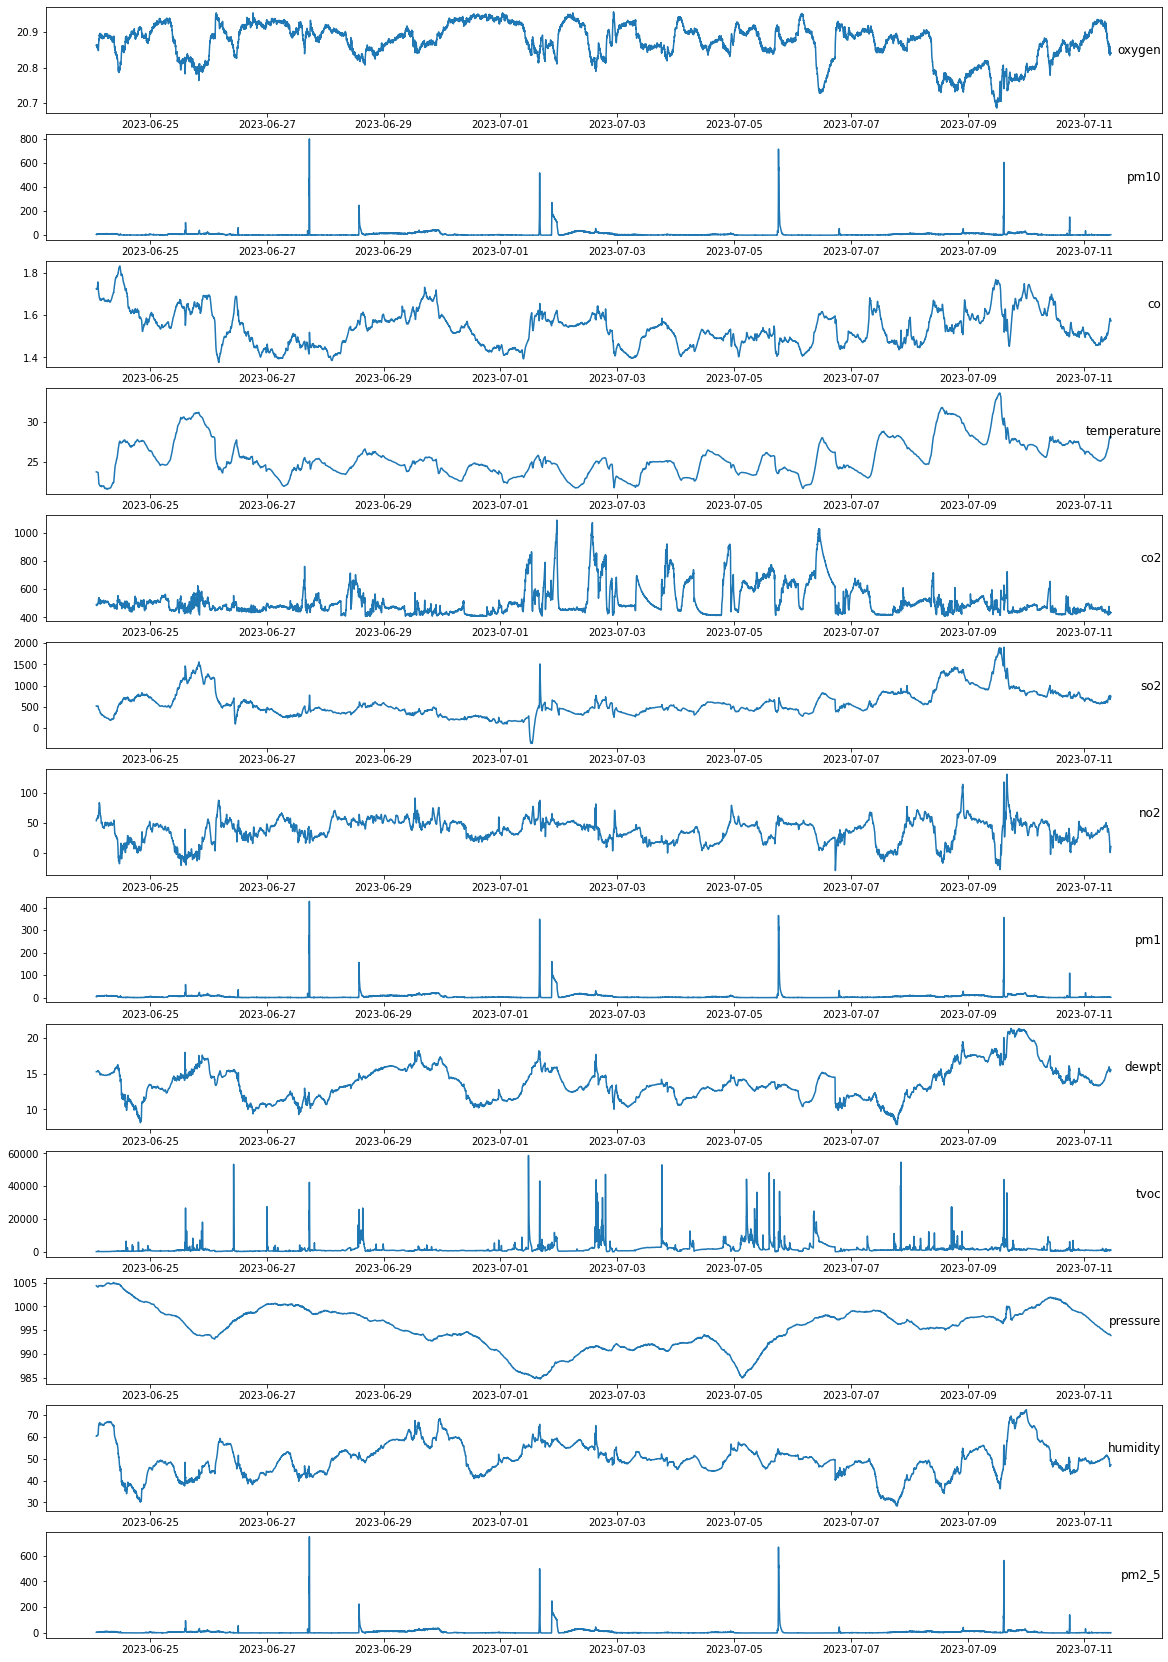

In [552]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

In [553]:
data

,oxygen,pm10,co,temperature,co2,so2,no2,pm1,dewpt,tvoc,pressure,humidity,pm2_5
date,,,,,,,,,,,,,
2023-06-24 01:59:10,20.863,6.004,1.726,23.718,490.458,518.956,53.683,4.772,15.243,88.673,1004.360,60.385,5.402
2023-06-24 02:01:10,20.863,6.891,1.726,23.715,490.505,520.396,54.946,5.906,15.239,87.726,1004.340,60.377,6.451
2023-06-24 02:03:11,20.863,7.486,1.726,23.716,489.080,520.139,55.795,5.004,15.235,98.224,1004.320,60.358,6.107
2023-06-24 02:05:11,20.862,5.874,1.726,23.719,488.189,518.782,56.146,4.991,15.255,91.344,1004.300,60.426,5.489
2023-06-24 02:07:11,20.864,7.068,1.725,23.712,485.401,516.398,56.341,5.839,15.251,85.264,1004.280,60.435,6.723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 10:41:40,20.842,3.159,1.578,27.999,432.277,715.633,7.023,2.007,15.321,955.380,993.977,47.086,2.733
2023-07-11 10:43:40,20.843,2.592,1.577,28.029,433.938,723.661,8.350,1.668,15.398,977.042,993.949,47.237,2.277
2023-07-11 10:45:42,20.840,3.614,1.575,28.074,435.733,733.135,9.782,2.233,15.457,984.612,993.952,47.292,3.254


**Multivariate LSTM Predictive Modeling**

In [554]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [555]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [556]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-2,-3,-10]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var1(t),var2(t),var3(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var13(t)
1,0.652016,0.007486,0.763676,0.181498,0.121727,0.389184,0.517380,0.011164,0.549683,0.001507,...,0.652016,0.008592,0.763676,0.121795,0.389819,0.525309,0.013817,0.549384,0.001491,0.008636
2,0.652016,0.008592,0.763676,0.181252,0.121795,0.389819,0.525309,0.013817,0.549384,0.001491,...,0.652016,0.009334,0.763676,0.119705,0.389705,0.530639,0.011707,0.549085,0.001670,0.008175
3,0.652016,0.009334,0.763676,0.181334,0.119705,0.389705,0.530639,0.011707,0.549085,0.001670,...,0.648346,0.007324,0.763676,0.118399,0.389107,0.532842,0.011677,0.550579,0.001553,0.007348
4,0.648346,0.007324,0.763676,0.181580,0.118399,0.389107,0.532842,0.011677,0.550579,0.001553,...,0.655678,0.008813,0.761488,0.114310,0.388056,0.534066,0.013661,0.550280,0.001449,0.009000
5,0.655678,0.008813,0.761488,0.181006,0.114310,0.388056,0.534066,0.013661,0.550280,0.001449,...,0.655678,0.008857,0.759300,0.112774,0.387212,0.535240,0.011978,0.550205,0.001466,0.007897


In [557]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-10].values, train.iloc[:, -10:].values
test_X, test_y = test.iloc[:, :-10].values, test.iloc[:, -10:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(9956, 1, 13) (9956, 10) (2489, 1, 13) (2489, 10)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [558]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(10))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 50)                12800     
_________________________________________________________________
dropout_37 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                510       
Total params: 13,310
Trainable params: 13,310
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/200
277/277 - 1s - loss: 0.1097 - val_loss: 0.1044
Epoch 2/200
277/277 - 1s - loss: 0.0686 - val_loss: 0.0784
Epoch 3/200
277/277 - 0s - loss: 0.0529 - val_loss: 0.0662
Epoch 4/200
277/277 - 0s - loss: 0.0454 - val_loss: 0.0608
Epoch 5/200
277/277 - 0s - loss: 0.0410 - val_loss: 0.0553
Epoch 6/200
277/277 - 0s - loss: 0.0384 - val_loss: 0.0524
Epoch 7/200
277/277 - 0s - loss: 0.0363 - val_loss: 0.0486
Epoch 8/200
277/277 - 0s - loss: 0.0346 - val_loss: 0.0471
Epoch 9/200
277/277 - 0s - loss: 0.0329 - val_loss: 0.0439
Epoch 10/200
277/277 - 0s - loss: 0.0320 - val_loss: 0.0425
Epoch 11/200
277/277 - 0s - loss: 0.0311 - val_loss: 0.0392
Epoch 12/200
277/277 - 0s - loss: 0.0303 - val_loss: 0.0366
Epoch 13/200
277/277 - 0s - loss: 0.0298 - val_loss: 0.0352
Epoch 14/200
277/277 - 0s - loss: 0.0295 - val_loss: 0.0359
Epoch 15/200
277/277 - 0s - loss: 0.0291 - val_loss: 0.0327
Epoch 16/200
277/277 - 1s - loss: 0.0288 - val_loss: 0.0321
Epoch 17/200
277/277 - 0s - loss: 0.0285 - val_lo

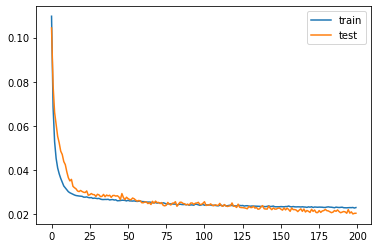

In [559]:
history = model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

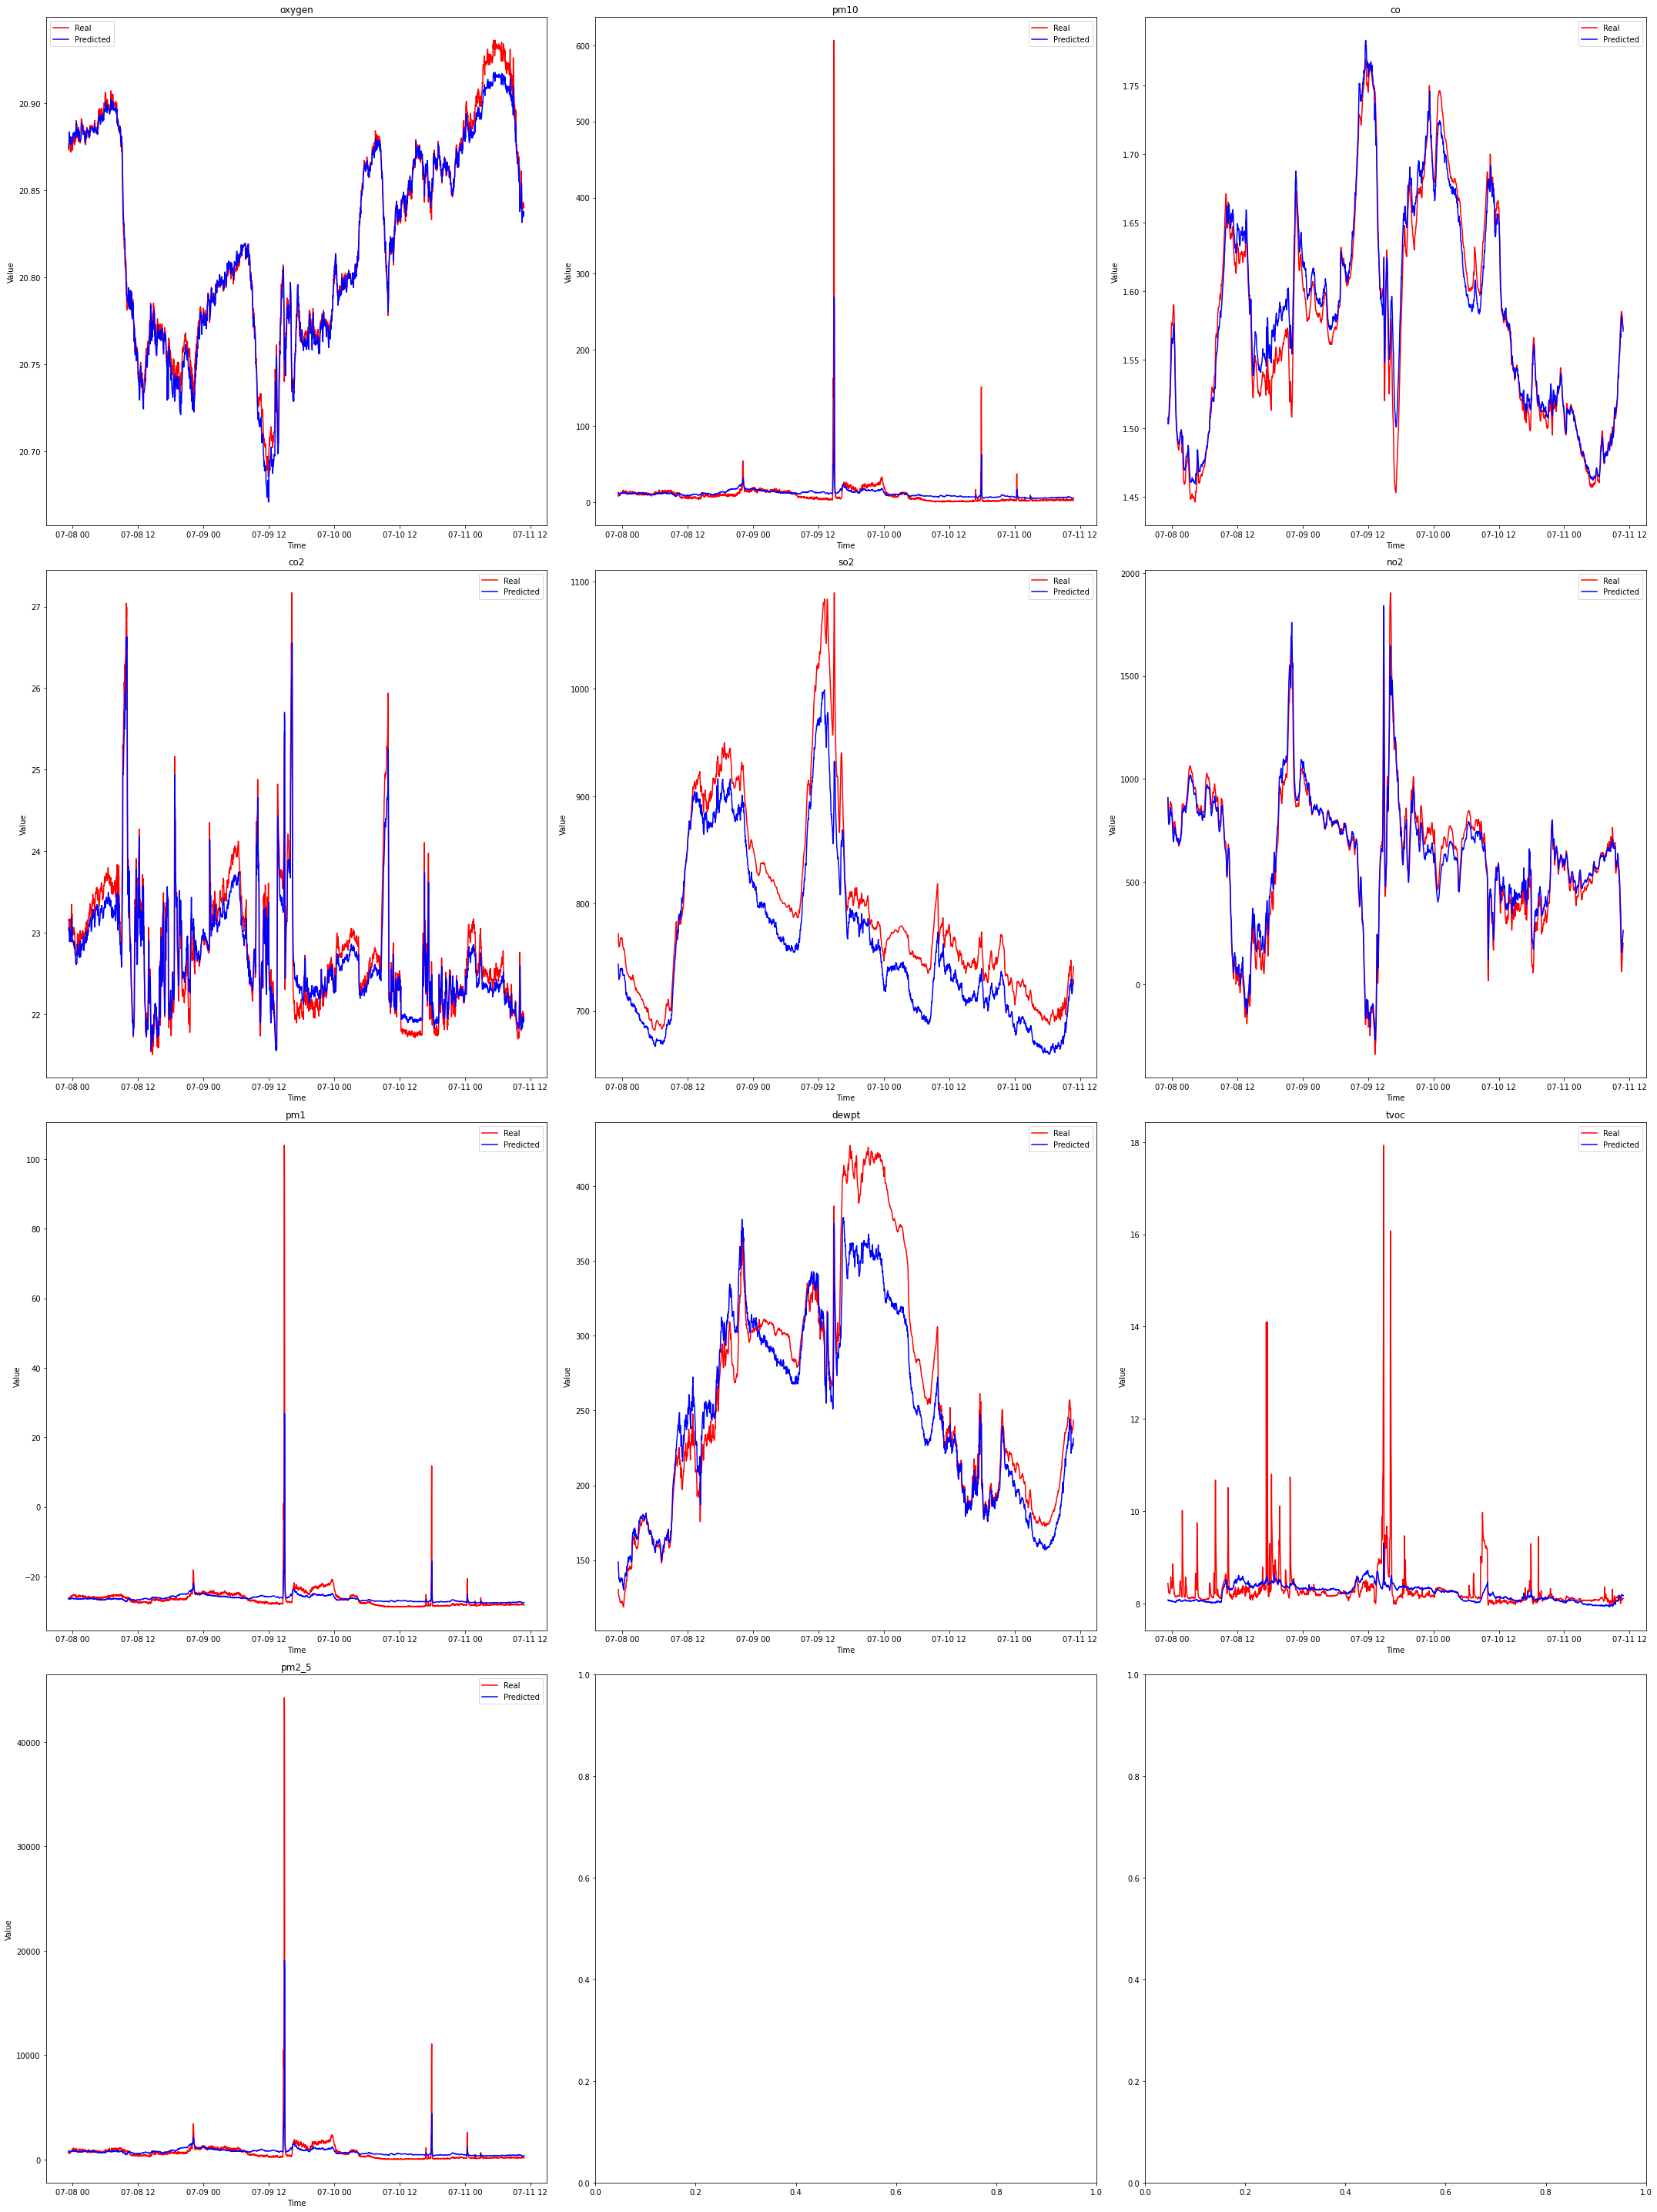

In [560]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [3, 10, 11]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), 10))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
dates = dates[-2489:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'pm2_5': 9
}
for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [561]:
print(inv_y.shape, inv_yhat.shape)

(2489, 13) (2489, 13)


In [562]:
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# selected_columns = [i for i in range(test_X.shape[1]) if i in [3, 10, 11]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]

# inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# oxygen_predict = inv_yhat[:, 0]
# oxygen_predict = inv_yhat[:, 0]
# oxygen_predict = inv_yhat[:, 0]

# test_y = test_y.reshape((len(test_y), 10))
# inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, 0]
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


(2489, 10) (2489, 10)
Test RMSE: 333.719


anticiper

In [563]:
n_seconds = 7
n_features = 13

reframed = series_to_supervised(scaled, n_seconds, 1)

In [564]:
reframed.drop(reframed.columns[[-2,-3,-10]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var1(t),var2(t),var3(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var13(t)
7,0.652016,0.007486,0.763676,0.181498,0.121727,0.389184,0.517380,0.011164,0.549683,0.001507,...,0.652016,0.008789,0.757112,0.115279,0.385335,0.533991,0.012343,0.550429,0.001476,0.008455
8,0.652016,0.008592,0.763676,0.181252,0.121795,0.389819,0.525309,0.013817,0.549384,0.001491,...,0.655678,0.009619,0.759300,0.115752,0.384858,0.534386,0.014250,0.551549,0.001593,0.009624
9,0.652016,0.009334,0.763676,0.181334,0.119705,0.389705,0.530639,0.011707,0.549085,0.001670,...,0.655678,0.008591,0.761488,0.119245,0.384773,0.536508,0.012694,0.552296,0.001630,0.008112
10,0.648346,0.007324,0.763676,0.181580,0.118399,0.389107,0.532842,0.011677,0.550579,0.001553,...,0.655678,0.009048,0.761488,0.119999,0.385144,0.537387,0.013036,0.551400,0.002238,0.009314
11,0.655678,0.008813,0.761488,0.181006,0.114310,0.388056,0.534066,0.013661,0.550280,0.001449,...,0.630035,0.007789,0.768053,0.121418,0.386124,0.539101,0.012603,0.552146,0.003386,0.008089
12,0.655678,0.008857,0.759300,0.180431,0.112774,0.387212,0.535240,0.011978,0.550205,0.001466,...,0.630035,0.009407,0.772429,0.125503,0.386923,0.541926,0.012919,0.552520,0.003392,0.009522
13,0.655678,0.008218,0.759300,0.180431,0.112717,0.386141,0.534776,0.012386,0.550280,0.001472,...,0.641022,0.008095,0.776805,0.123783,0.387452,0.544192,0.012776,0.552818,0.003172,0.008471
14,0.652016,0.008789,0.757112,0.180513,0.115279,0.385335,0.533991,0.012343,0.550429,0.001476,...,0.626373,0.009595,0.781182,0.132610,0.387680,0.547701,0.015163,0.555431,0.002926,0.009887
15,0.655678,0.009619,0.759300,0.180349,0.115752,0.384858,0.534386,0.014250,0.551549,0.001593,...,0.630035,0.009814,0.783370,0.134140,0.387311,0.550457,0.014709,0.556178,0.002631,0.009942
16,0.655678,0.008591,0.761488,0.180349,0.119245,0.384773,0.536508,0.012694,0.552296,0.001630,...,0.619041,0.009958,0.792123,0.131066,0.387344,0.552108,0.015106,0.555804,0.002414,0.010300


In [565]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9956, 91) (9956, 10) (2483, 91) (2483, 10)


In [566]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(2483, 7, 13) (9956, 7, 13)


In [567]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(10))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 50)                12800     
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                510       
Total params: 13,310
Trainable params: 13,310
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/200
277/277 - 1s - loss: 0.1094 - val_loss: 0.0958
Epoch 2/200
277/277 - 1s - loss: 0.0616 - val_loss: 0.0756
Epoch 3/200
277/277 - 1s - loss: 0.0476 - val_loss: 0.0673
Epoch 4/200
277/277 - 1s - loss: 0.0412 - val_loss: 0.0574
Epoch 5/200
277/277 - 1s - loss: 0.0377 - val_loss: 0.0511
Epoch 6/200
277/277 - 1s - loss: 0.0353 - val_loss: 0.0466
Epoch 7/200
277/277 - 1s - loss: 0.0337 - val_loss: 0.0452
Epoch 8/200
277/277 - 1s - loss: 0.0322 - val_loss: 0.0447
Epoch 9/200
277/277 - 1s - loss: 0.0314 - val_loss: 0.0391
Epoch 10/200
277/277 - 1s - loss: 0.0310 - val_loss: 0.0380
Epoch 11/200
277/277 - 1s - loss: 0.0306 - val_loss: 0.0383
Epoch 12/200
277/277 - 1s - loss: 0.0302 - val_loss: 0.0399
Epoch 13/200
277/277 - 1s - loss: 0.0299 - val_loss: 0.0385
Epoch 14/200
277/277 - 1s - loss: 0.0298 - val_loss: 0.0343
Epoch 15/200
277/277 - 1s - loss: 0.0293 - val_loss: 0.0324
Epoch 16/200
277/277 - 1s - loss: 0.0296 - val_loss: 0.0326
Epoch 17/200
277/277 - 1s - loss: 0.0293 - val_lo

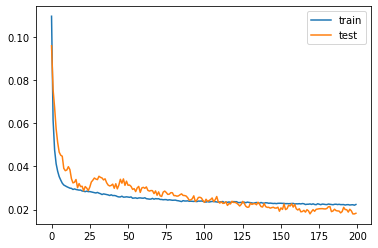

In [568]:
history = model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

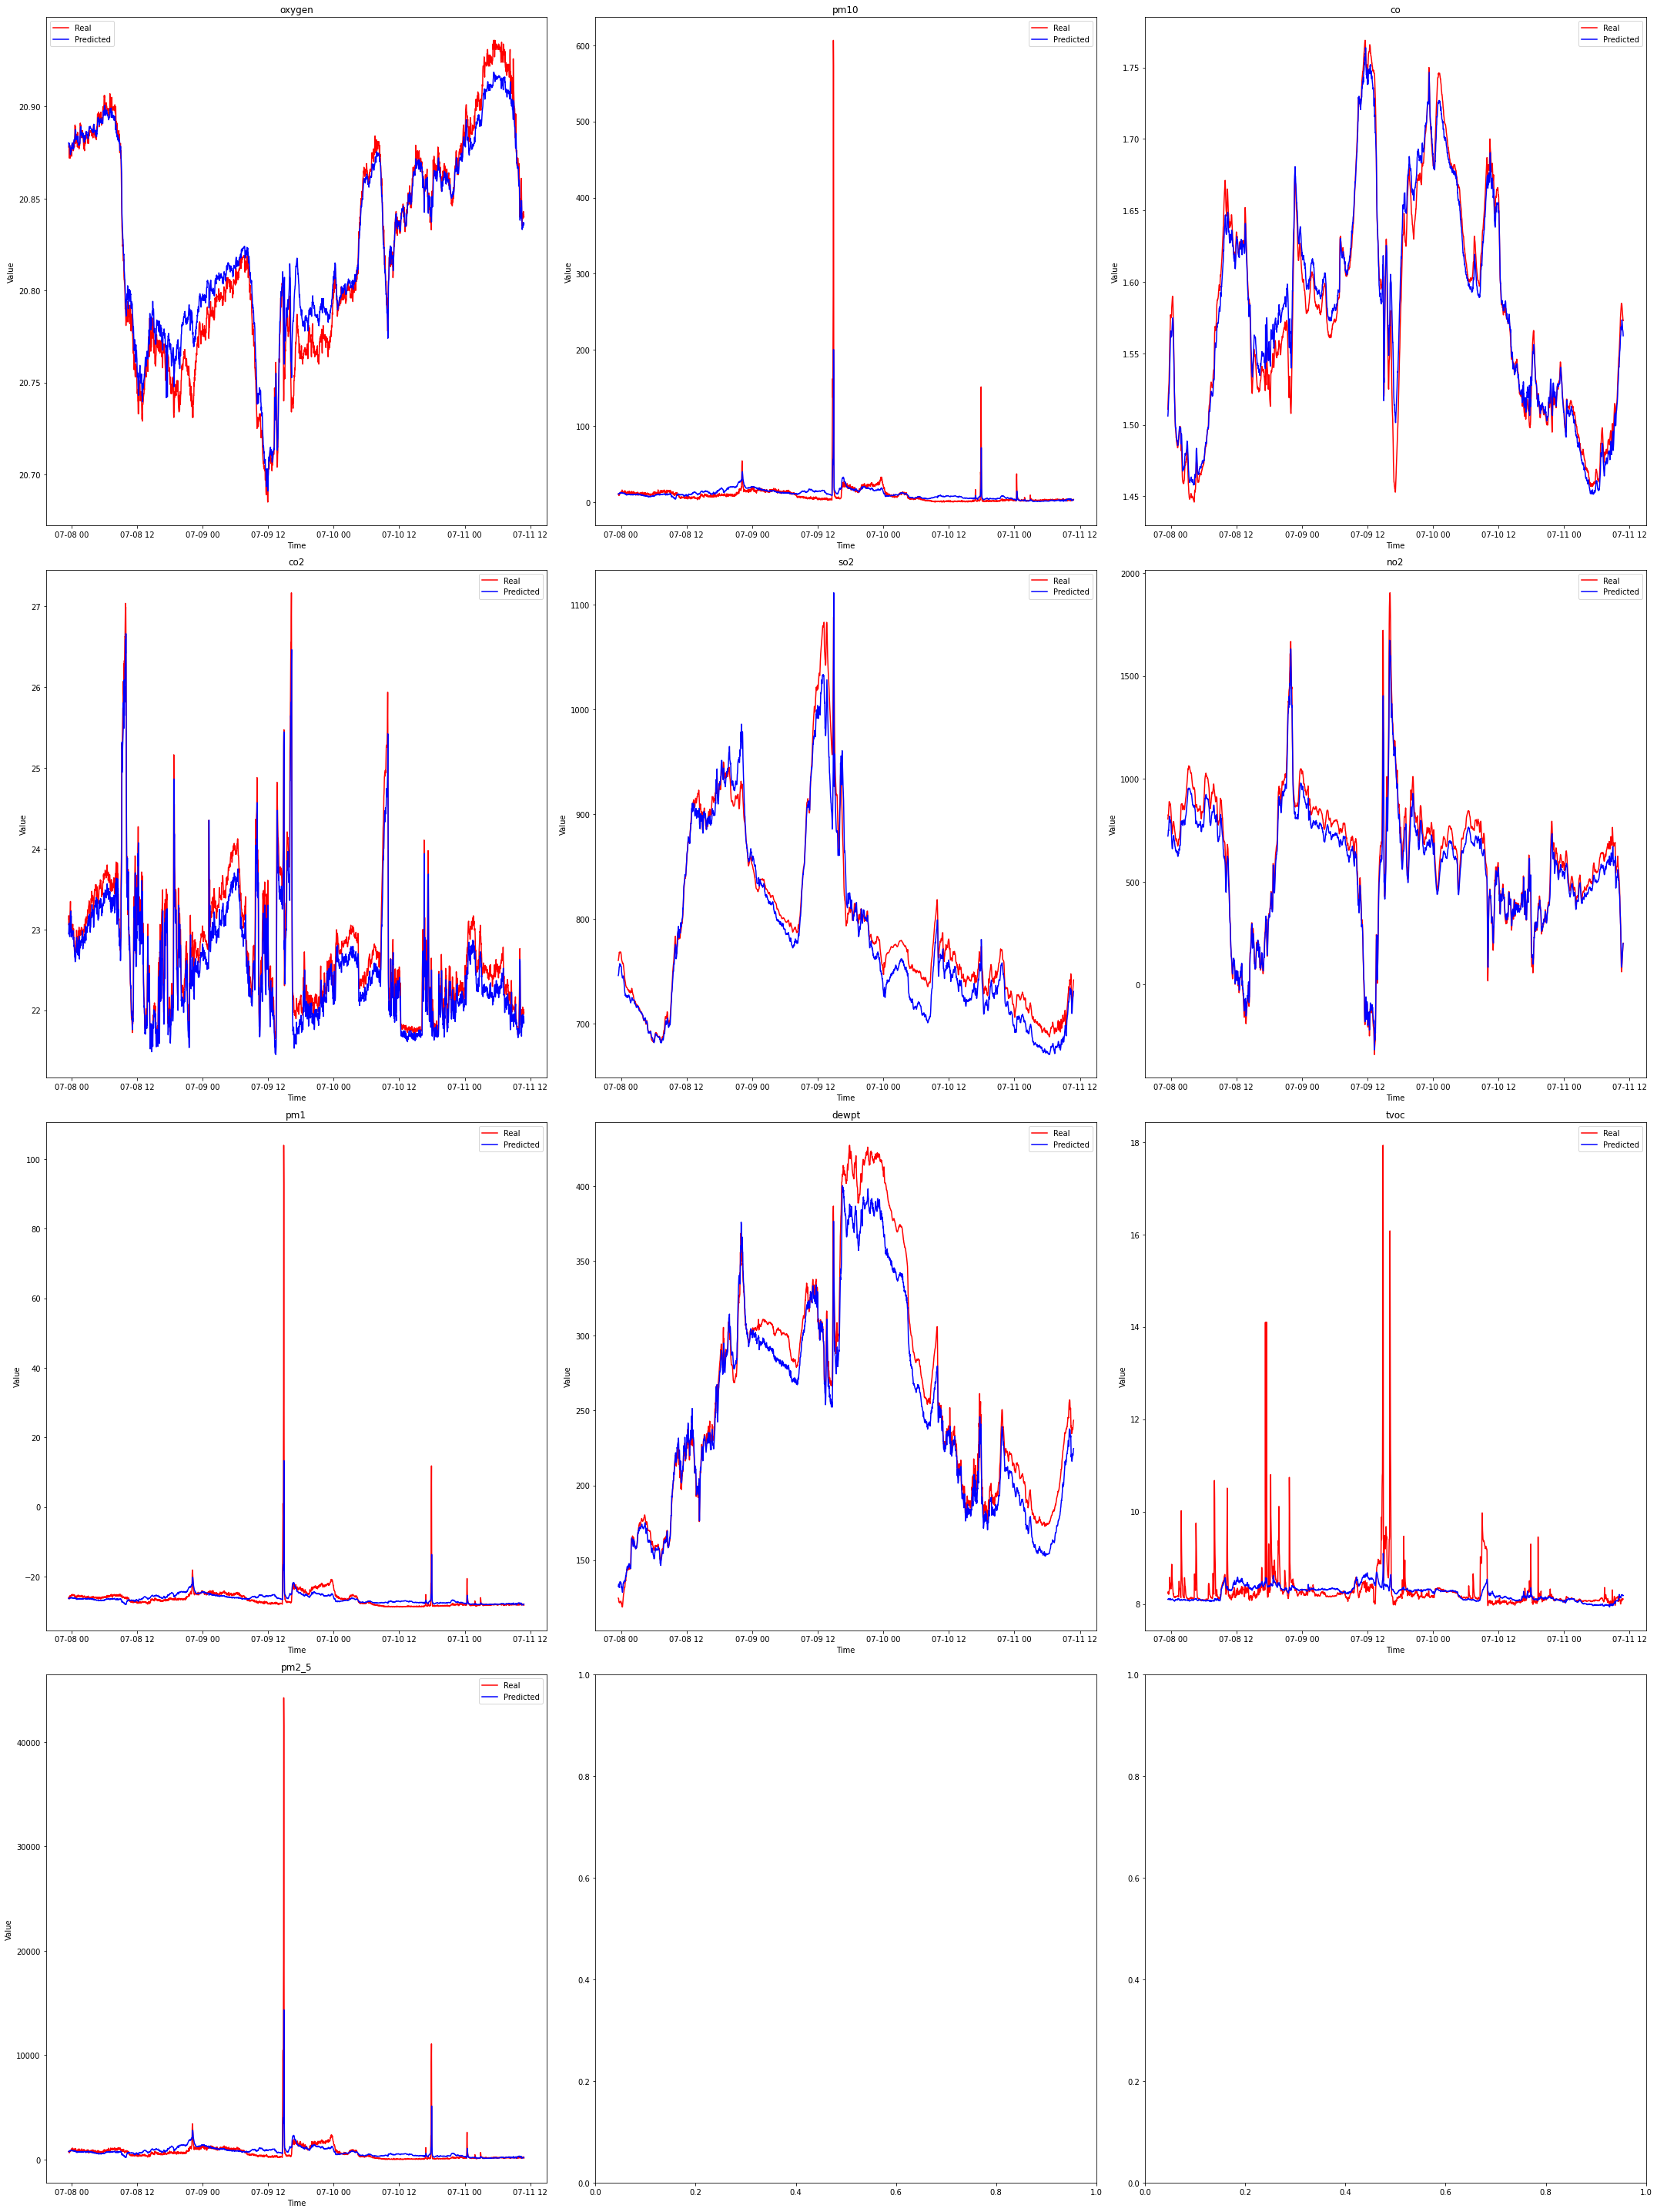

In [569]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [3, 10, 11]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape((len(test_y), 10))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, selected_columns2]

dates = dates[-2483:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'pm2_5': 9
}
for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [570]:
print(inv_y.shape, inv_yhat.shape)

(2483, 13) (2483, 13)


In [571]:
selected_columns2 = [i for i in range(n_features) if i not in [3, 10, 11]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [572]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 351.728
